# Projeto: Previsão de Preços de Imóveis em Ames

### Importação das Bibliotecas Necessárias

In [99]:
# Manipulação de Dados
import pathlib
import pickle
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configurações Gerais
%matplotlib inline
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

### Carregamento e Visualização dos Dados

In [100]:
# Definir o caminho para o diretório de dados
DATA_DIR = pathlib.Path.cwd().parent / 'data'

# Construir o caminho completo para o arquivo
data_path = DATA_DIR / 'processed' / 'ames_with_correct_types.pkl'

# Verificar se o arquivo existe
if data_path.exists():
    print("Dados encontrados. Carregando o arquivo...")
    with open(data_path, 'rb') as file:
        data, continuous_variables, discrete_variables, ordinal_variables, categorical_variables = pickle.load(file)
    print("Dados carregados com sucesso.")
else:
    print("Erro: O arquivo não foi encontrado. Verifique o caminho e tente novamente.")

# Criar uma cópia do dataframe para manipulação
df = data.copy()

# Visualizar as primeiras linhas do dataframe
df.head()

Dados encontrados. Carregando o arquivo...
Dados carregados com sucesso.


,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,20,RL,141.0,31770.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960.0,1960.0,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1.0,0.0,1.0,0.0,3.0,1.0,TA,7.0,Typ,2.0,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,5.0,2010.0,WD,Normal,215000.0
1,20,RH,80.0,11622.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961.0,1961.0,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,1.0,TA,5.0,Typ,0.0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,NaN,MnPrv,NaN,0.0,6.0,2010.0,WD,Normal,105000.0
2,20,RL,81.0,14267.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958.0,1958.0,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,1.0,Gd,6.0,Typ,0.0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,NaN,NaN,Gar2,12500.0,6.0,2010.0,WD,Normal,172000.0
3,20,RL,93.0,11160.0,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968.0,1968.0,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1.0,0.0,2.0,1.0,3.0,1.0,Ex,8.0,Typ,2.0,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,4.0,2010.0,WD,Normal,244000.0
4,60,RL,74.0,13830.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997.0,1998.0,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,NaN,MnPrv,NaN,0.0,3.0,2010.0,WD,Normal,189900.0


### Análise Exploratória de Dados (EDA)

#### Informações Gerais

In [101]:
# Informações sobre o dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2930 non-null   category
 1   MS.Zoning        2930 non-null   category
 2   Lot.Frontage     2440 non-null   float64 
 3   Lot.Area         2930 non-null   float64 
 4   Street           2930 non-null   category
 5   Alley            198 non-null    category
 6   Lot.Shape        2930 non-null   category
 7   Land.Contour     2930 non-null   category
 8   Utilities        2930 non-null   category
 9   Lot.Config       2930 non-null   category
 10  Land.Slope       2930 non-null   category
 11  Neighborhood     2930 non-null   category
 12  Condition.1      2930 non-null   category
 13  Condition.2      2930 non-null   category
 14  Bldg.Type        2930 non-null   category
 15  House.Style      2930 non-null   category
 16  Overall.Qual     2930 non-null   category


#### Análise de Valores Ausentes

In [102]:
# Calcular a porcentagem de valores ausentes em cada coluna
missing_percent = df.isnull().mean() * 100

# Exibir as colunas com valores ausentes
missing_percent[missing_percent > 0].sort_values(ascending=False)

Pool.QC           99.556314
Misc.Feature      96.382253
Alley             93.242321
Fence             80.477816
Mas.Vnr.Type      60.580205
Fireplace.Qu      48.532423
Lot.Frontage      16.723549
Garage.Cond        5.426621
Garage.Qual        5.426621
Garage.Finish      5.426621
Garage.Yr.Blt      5.426621
Garage.Type        5.358362
Bsmt.Exposure      2.832765
BsmtFin.Type.2     2.764505
Bsmt.Cond          2.730375
Bsmt.Qual          2.730375
BsmtFin.Type.1     2.730375
Mas.Vnr.Area       0.784983
Bsmt.Half.Bath     0.068259
Bsmt.Full.Bath     0.068259
BsmtFin.SF.1       0.034130
Garage.Cars        0.034130
Garage.Area        0.034130
Total.Bsmt.SF      0.034130
Bsmt.Unf.SF        0.034130
BsmtFin.SF.2       0.034130
Electrical         0.034130
dtype: float64

#### Visualização de Distribuições

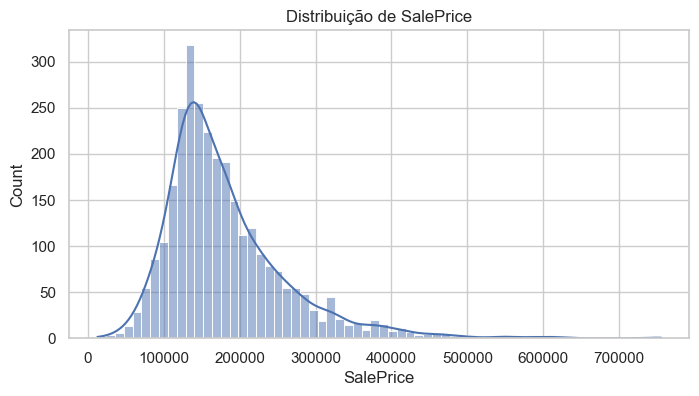

In [103]:
# Visualizar a distribuição de 'SalePrice'
plt.figure(figsize=(8, 4))
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribuição de SalePrice')
plt.show()

#### Análise de Correlação

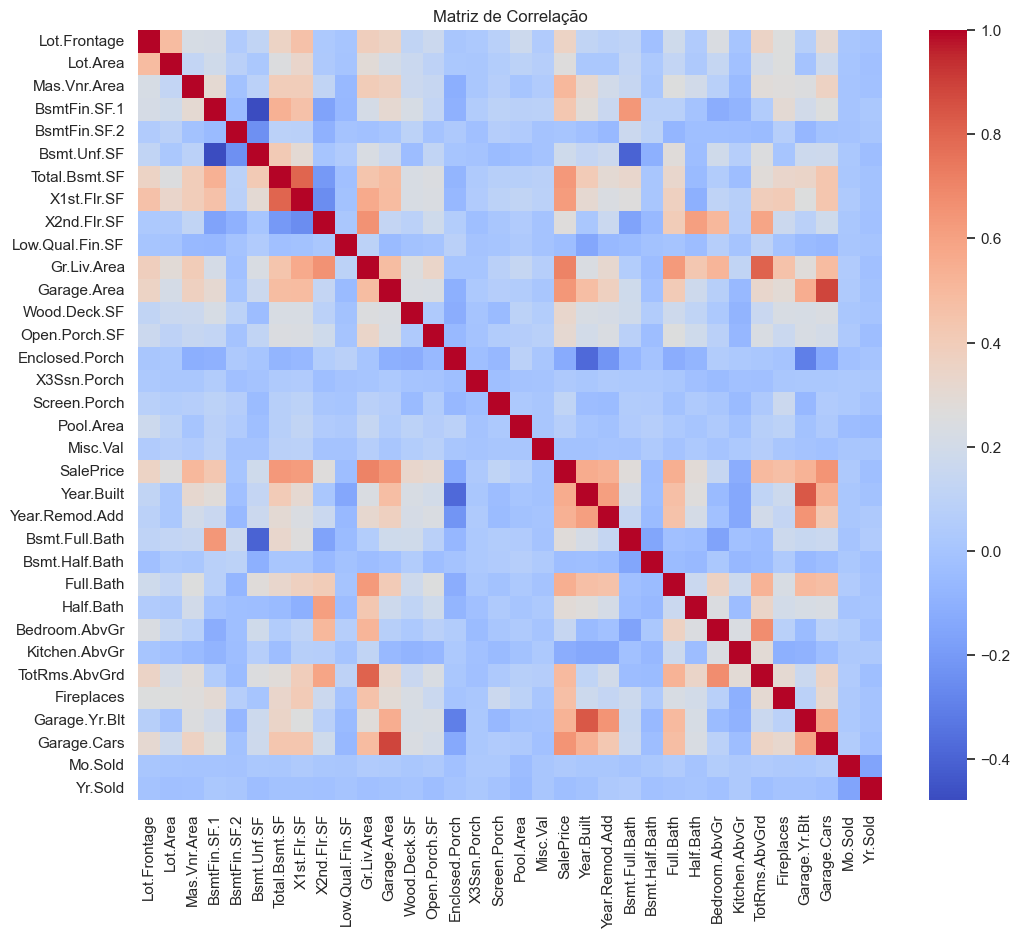

In [104]:
# Matriz de correlação das variáveis numéricas
numeric_cols = continuous_variables + discrete_variables
corr_matrix = df[numeric_cols].corr()

# Heatmap da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

### Engenharia de Features

#### Tratamento de Valores Ausentes

Remover Colunas com Muitos Valores Ausentes

In [105]:
# Identificar colunas com mais de 50% de valores ausentes
cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
print(f'Colunas a serem removidas devido a muitos valores ausentes: {cols_to_drop}')

# Remover as colunas
df.drop(columns=cols_to_drop, inplace=True)

Colunas a serem removidas devido a muitos valores ausentes: ['Alley', 'Mas.Vnr.Type', 'Pool.QC', 'Fence', 'Misc.Feature']


Imputação de Valores Ausentes

In [ ]:
# Imputação para variáveis numéricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Imputação para variáveis categóricas
cat_cols = df.select_dtypes(include=['category']).columns
for col in cat_cols:
    if df[col].isnull().any():
        df[col] = df[col].cat.add_categories(['Missing'])
        df[col] = df[col].fillna('Missing')

#### Transformação da Variável Alvo

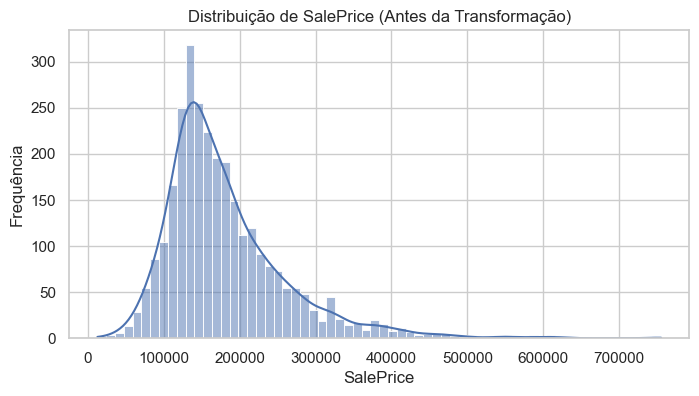

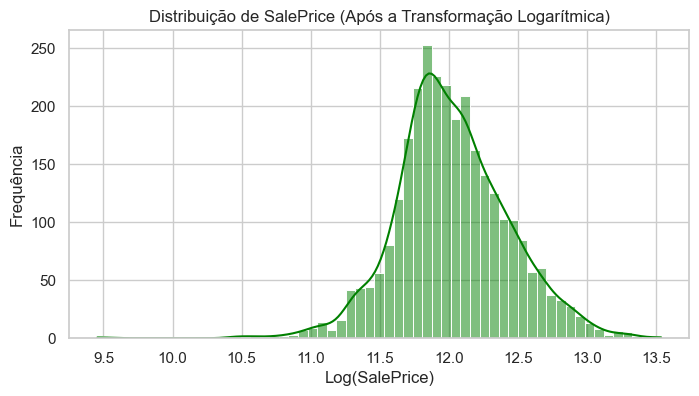

In [107]:
# Histograma de SalePrice antes da transformação
plt.figure(figsize=(8, 4))
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribuição de SalePrice (Antes da Transformação)')
plt.xlabel('SalePrice')
plt.ylabel('Frequência')
plt.show()

# Aplicar logaritmo natural
df['SalePrice'] = np.log(df['SalePrice'])

# Histograma de SalePrice após a transformação
plt.figure(figsize=(8, 4))
sns.histplot(df['SalePrice'], kde=True, color='green')
plt.title('Distribuição de SalePrice (Após a Transformação Logarítmica)')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequência')
plt.show()

#### Criação de Novas Features

Total de Banheiros

In [108]:
# Criar uma nova feature somando todos os banheiros
df['TotalBathrooms'] = (
    df['Bsmt.Full.Bath'] + (0.5 * df['Bsmt.Half.Bath']) +
    df['Full.Bath'] + (0.5 * df['Half.Bath'])
)

Idade da Casa

In [109]:
# Calcular a idade da casa no ano da venda
df['HouseAge'] = df['Yr.Sold'] - df['Year.Built']
df['HouseAge'] = df['HouseAge'].apply(lambda x: x if x >= 0 else 0)

Área Total

In [110]:
# Somar áreas relevantes
df['TotalSF'] = df['Total.Bsmt.SF'] + df['X1st.Flr.SF'] + df['X2nd.Flr.SF']

### Divisão dos Dados em Treino e Teste

In [111]:
# Separar features e target
X = df.drop(columns='SalePrice')
y = df['SalePrice']

# Dividir os dados em treinamento e teste (75% treino, 25% teste)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

### Codificação de Variáveis Categóricas

In [112]:
from sklearn.preprocessing import OneHotEncoder

# Identificar colunas categóricas e numéricas
categorical_cols = X_train.select_dtypes(include=['category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Inicializar o OneHotEncoder com o parâmetro atualizado
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Ajustar o encoder nos dados de treinamento e transformar os dados de treinamento e teste
X_train_cat = ohe.fit_transform(X_train[categorical_cols])
X_test_cat = ohe.transform(X_test[categorical_cols])

# Obter os nomes das novas colunas
ohe_columns = ohe.get_feature_names_out(categorical_cols)

# Converter para DataFrame e manter o índice original
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe_columns, index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat, columns=ohe_columns, index=X_test.index)

# Concatenar as features numéricas e categóricas
X_train = pd.concat([X_train[numerical_cols].reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test[numerical_cols].reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

### Escalonamento das Features

In [113]:
from sklearn.preprocessing import StandardScaler

# Inicializar o escalonador
scaler = StandardScaler()

# Ajustar o escalonador nos dados de treinamento
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Transformar os dados de teste
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Construção e Treinamento de Múltiplos Modelos de Regressão

#### Regressão Linear Simples

In [114]:
# Instanciar o modelo
lr_model = LinearRegression()

# Treinar o modelo
lr_model.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred_lr = lr_model.predict(X_test)

# Calcular o RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f'RMSE Regressão Linear: {rmse_lr:.4f}')

RMSE Regressão Linear: 6175571587.6826


#### Regressão Ridge

In [115]:
# Definir a grade de hiperparâmetros
ridge_params = {'alpha': np.logspace(-3, 3, 7)}

# Instanciar o modelo
ridge = Ridge()

# Configurar o GridSearchCV
ridge_grid = GridSearchCV(
    ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# Treinar o modelo
ridge_grid.fit(X_train, y_train)

# Melhor modelo e hiperparâmetros
best_ridge = ridge_grid.best_estimator_
print(f'Melhor alpha para Ridge: {ridge_grid.best_params_['alpha']}')

# Previsões e RMSE
y_pred_ridge = best_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f'RMSE Regressão Ridge: {rmse_ridge:.4f}')

Melhor alpha para Ridge: 10.0
RMSE Regressão Ridge: 0.1201


#### Regressão Lasso

In [116]:
# Definir a grade de hiperparâmetros
lasso_params = {'alpha': np.logspace(-3, 1, 5)}

# Instanciar o modelo
lasso = Lasso(max_iter=10000)

# Configurar o GridSearchCV
lasso_grid = GridSearchCV(
    lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# Treinar o modelo
lasso_grid.fit(X_train, y_train)

# Melhor modelo e hiperparâmetros
best_lasso = lasso_grid.best_estimator_
print(f'Melhor alpha para Lasso: {lasso_grid.best_params_['alpha']}')

# Previsões e RMSE
y_pred_lasso = best_lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f'RMSE Regressão Lasso: {rmse_lasso:.4f}')

Melhor alpha para Lasso: 0.001
RMSE Regressão Lasso: 0.1216


#### Random Forest Regressor

In [117]:
# Definir a grade de hiperparâmetros
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# Instanciar o modelo
rf = RandomForestRegressor(random_state=42)

# Configurar o GridSearchCV
rf_grid = GridSearchCV(
    rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# Treinar o modelo
rf_grid.fit(X_train, y_train)

# Melhor modelo e hiperparâmetros
best_rf = rf_grid.best_estimator_
print(f'Melhores hiperparâmetros para Random Forest: {rf_grid.best_params_}')

# Previsões e RMSE
y_pred_rf = best_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'RMSE Random Forest: {rmse_rf:.4f}')

Melhores hiperparâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RMSE Random Forest: 0.1331


### Comparação dos Desempenhos dos Modelos

In [118]:
# Criar um DataFrame com os resultados
results = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Regressão Ridge', 'Regressão Lasso', 'Random Forest'],
    'RMSE': [rmse_lr, rmse_ridge, rmse_lasso, rmse_rf]
})

# Ordenar por RMSE
results = results.sort_values('RMSE').reset_index(drop=True)
print(results)

             Modelo          RMSE
0   Regressão Ridge  1.201364e-01
1   Regressão Lasso  1.215917e-01
2     Random Forest  1.330917e-01
3  Regressão Linear  6.175572e+09


#### Visualização dos Resultados

/var/folders/7z/7g0_7d1s7hn1n8_mh8f0c2pw0000gn/T/ipykernel_4587/3609189899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Modelo', data=results, palette='viridis')


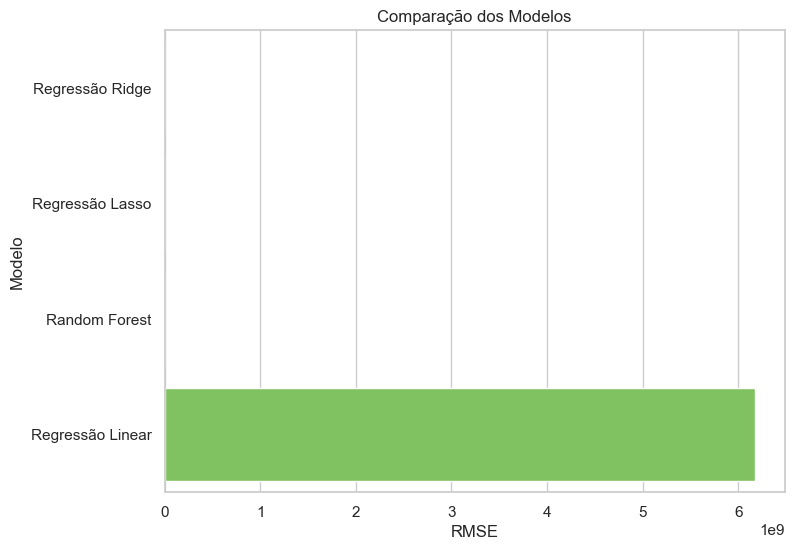

In [119]:
plt.figure(figsize=(8, 6))
sns.barplot(x='RMSE', y='Modelo', data=results, palette='viridis')
plt.title('Comparação dos Modelos')
plt.xlabel('RMSE')
plt.ylabel('Modelo')
plt.show()

### Avaliação do Modelo Selecionado

#### Métricas de Desempenho no Conjunto de Teste